In [1]:
# SOJA. DESCRIPCIÓN MORFOLÓGICA
# GRUPO 12
# MIRANDA, ERICK ENRIQUE
# RIOS, DANIEL RICARDO
# SERRANO, EDUARDO ALFREDO ADRIÁN

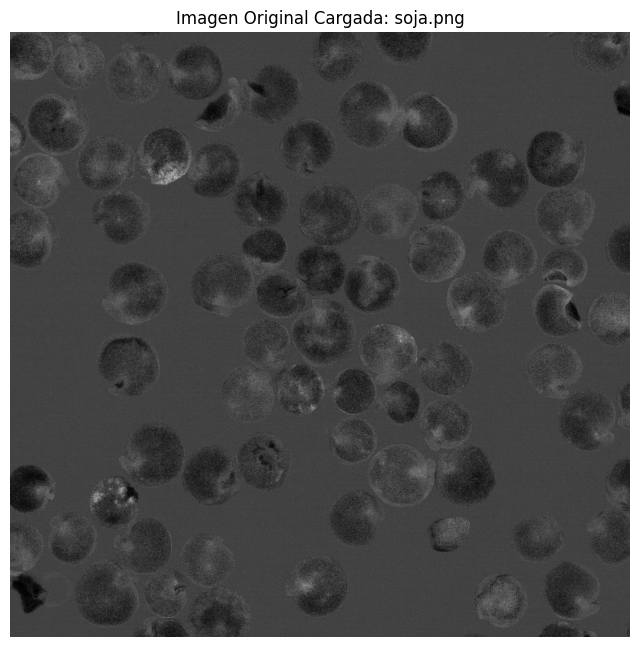

Carga exitosa. Dimensiones de la imagen: (5550, 5683, 3)


In [2]:
# 1. IMPORTACIÓN DE LIBRERÍAS Y CARGA DE IMAGEN

# Importamos las herramientas necesarias:
# cv2 (OpenCV): La librería principal para procesamiento de imágenes.
import cv2
# matplotlib.pyplot: Para mostrar gráficos e imágenes de forma visual.
import matplotlib.pyplot as plt
# numpy: Para manejar las imágenes como matrices matemáticas de números.
import numpy as np

# Definimos el nombre del archivo.
filename = 'soja.png'

# Leemos la imagen desde el disco.
# OpenCV carga las imágenes por defecto en formato BGR (Blue-Green-Red).
img_bgr = cv2.imread(filename)

# --- VERIFICACIÓN DE SEGURIDAD ---
# Es vital comprobar si la imagen se cargó. Si el archivo no existe o el nombre está mal,
# 'img_bgr' será 'None' y el programa fallaría más adelante.
if img_bgr is None:
    print(f"Error CRÍTICO: No se encuentra el archivo '{filename}'.")
    print("Por favor, verifica que subiste la imagen a la carpeta de archivos.")
else:
    # Si la imagen cargó bien, procedemos a mostrarla.

    # 1. Conversión de Color:
    # Matplotlib espera el orden RGB (Rojo-Verde-Azul), pero OpenCV usa BGR.
    # Si no convertimos, los colores se verán extraños (la soja se vería azulada).
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Configuración de la Visualización:
    # Creamos una figura de 8x8 pulgadas para que se vea grande y clara.
    plt.figure(figsize=(8, 8))

    # Mostramos la imagen convertida (RGB).
    plt.imshow(img_rgb)

    # Ponemos un título al gráfico.
    plt.title(f"Imagen Original Cargada: {filename}")

    # Desactivamos los ejes (los números de los píxeles en los bordes) para una vista más limpia.
    plt.axis('off')

    # Renderizamos (pintamos) el gráfico en pantalla.
    plt.show()

    # 3. Información Técnica:
    # Imprimimos las dimensiones: (Alto, Ancho, Canales de color).
    print(f"Carga exitosa. Dimensiones de la imagen: {img_bgr.shape}")

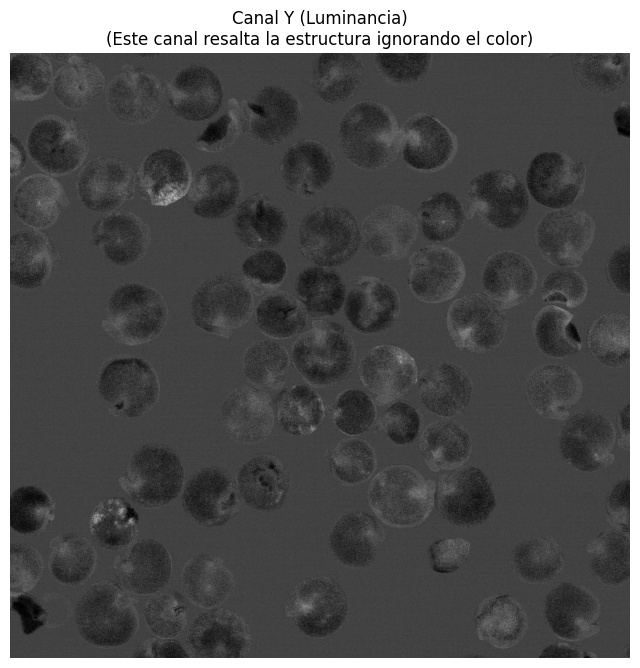

Proceso completado: Se ha extraído el canal de Luminancia (Y) para mejorar la detección de bordes.


In [3]:
# PASO 2: Conversión a espacio de color YCrCb y Extracción de Luminancia

# 1. Convertir la imagen de BGR a YCrCb
# A diferencia de RGB (que mezcla color y luz), YCrCb separa la información:
# Y  = Luminancia (Brillo/Intensidad) -> Contiene los detalles de la estructura y bordes.
# Cr = Componente Roja (Diferencia de rojo)
# Cb = Componente Azul (Diferencia de azul)
img_ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)

# 2. Separar los 3 canales
# Usamos cv2.split para dividir la imagen en sus tres matrices componentes.
# Aunque extraemos los 3, solo guardaremos y usaremos 'y_channel' para el análisis.
y_channel, cr_channel, cb_channel = cv2.split(img_ycrcb)

# 3. Visualizar SOLAMENTE el Canal Y
# Mostramos únicamente el canal de Luminancia, que es el que mejor define la forma
# de los granos y es ideal para la segmentación posterior.
plt.figure(figsize=(8, 8))
plt.imshow(y_channel, cmap='gray') # 'cmap=gray' es vital para ver la intensidad real
plt.title("Canal Y (Luminancia)\n(Este canal resalta la estructura ignorando el color)")
plt.axis('off') # Quitamos los ejes numéricos para limpieza visual
plt.show()

print("Proceso completado: Se ha extraído el canal de Luminancia (Y) para mejorar la detección de bordes.")

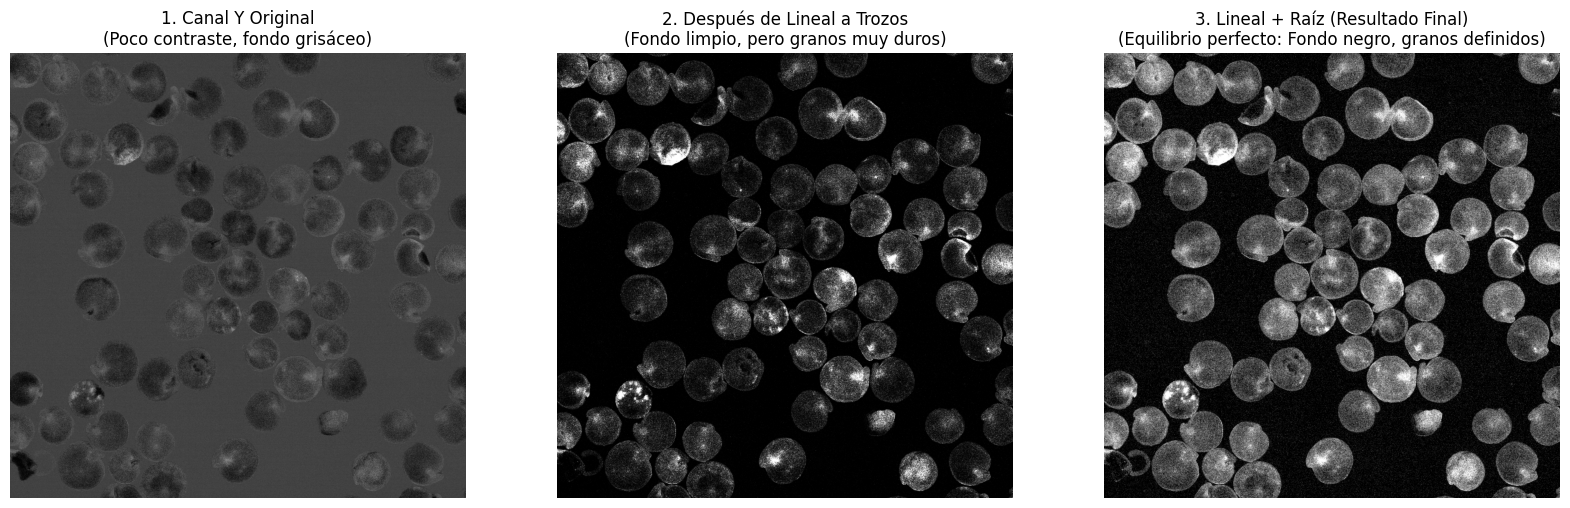

/tmp/ipython-input-3001317934.py:87: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(y_channel.ravel(), 256, [0, 256], color='gray', alpha=0.5, label='Original')
/tmp/ipython-input-3001317934.py:88: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(y_combined.ravel(), 256, [0, 256], color='green', alpha=0.5, label='Mejorada (Final)')


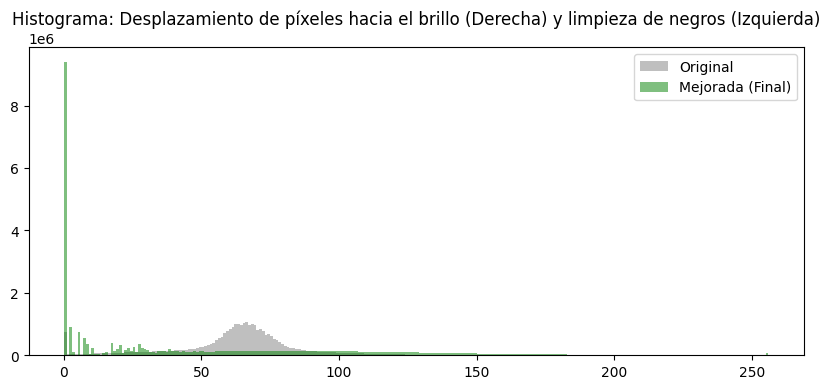

In [4]:
# PASO 3: Mejora de Contraste Híbrida (Lineal a Trozos + Raíz Cuadrada)

def piecewise_linear(img, r1, s1, r2, s2):
    """
    Función auxiliar para aplicar Transformación Lineal a Trozos.
    Funciona como una curva de niveles manual:

    - r1: Límite de sombras. Todo lo que sea más oscuro que esto se vuelve s1 (negro).
    - r2: Límite de luces. Todo lo que sea más claro que esto se vuelve s2 (blanco).
    - Lo que está en medio se estira para tener mejor contraste.
    """
    # Crear una 'Look-Up Table' (LUT). Es una lista de 256 valores que le dice
    # a la computadora: "Si ves el color X, cámbialo por Y". Es muy rápido.
    lut = []
    for i in range(256):
        if i < r1:
            lut.append(s1)      # Zona de ruido/fondo -> Forzar a Negro
        elif i > r2:
            lut.append(s2)      # Zona de grano seguro -> Forzar a Blanco
        else:
            # Ecuación de la recta para estirar suavemente los grises medios
            val = s1 + ((i - r1) * (s2 - s1) / (r2 - r1))
            lut.append(val)

    lut = np.array(lut, dtype=np.uint8)
    return cv2.LUT(img, lut)

# ---------------------------------------------------------
# 1. Fase 1: Estiramiento Lineal (Alto Contraste)
# ---------------------------------------------------------
# r1=80: Eliminamos sombras y manchas del fondo (se vuelven negro 0).
# r2=160: Saturamos los granos para que destaquen (se vuelven blanco 255).
gray = piecewise_linear(y_channel, r1=80, s1=0, r2=160, s2=255)

# Aplicamos un desenfoque gaussiano fuerte (9x9) para suavizar la textura interna
# del grano y que no parezca "granulado", sino un objeto sólido.
tophat = cv2.GaussianBlur(gray, (9, 9), 0)

# Multiplicamos la intensidad x3. Esto hace que los granos brillen mucho más,
# asegurando que se separen bien del fondo oscuro.
y_linear = cv2.multiply(tophat, 3)

# ---------------------------------------------------------
# 2. Fase 2: Corrección Gamma (Raíz Cuadrada)
# ---------------------------------------------------------
# El paso anterior es muy agresivo y puede dejar los granos como manchas blancas planas.
# La raíz cuadrada "suaviza" esa agresividad, recuperando contornos curvos.

# Convertimos a float (decimales) para poder calcular la raíz
y_float = y_linear.astype(np.float32) / 255.0

# Aplicamos raíz cuadrada (potencia 0.5). Esto levanta los medios tonos.
y_combined = cv2.pow(y_float, 0.5)

# Normalizamos para que los valores vuelvan a estar entre 0 y 255 (formato de imagen)
y_combined = cv2.normalize(y_combined, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Un último suavizado leve para eliminar cualquier borde dentado pixelado
y_combined = cv2.GaussianBlur(y_combined, (3, 3), 0)


# ---------------------------------------------------------
# 3. Visualización de Resultados
# ---------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Imagen Original (Canal Y)
axes[0].imshow(y_channel, cmap='gray')
axes[0].set_title("1. Canal Y Original\n(Poco contraste, fondo grisáceo)")
axes[0].axis('off')

# Resultado Intermedio (Solo Lineal)
axes[1].imshow(y_linear, cmap='gray')
axes[1].set_title("2. Después de Lineal a Trozos\n(Fondo limpio, pero granos muy duros)")
axes[1].axis('off')

# Resultado Final (Híbrido)
axes[2].imshow(y_combined, cmap='gray')
axes[2].set_title("3. Lineal + Raíz (Resultado Final)\n(Equilibrio perfecto: Fondo negro, granos definidos)")
axes[2].axis('off')

plt.show()

# Histograma para análisis técnico
# El histograma verde debería estar muy pegado a la derecha (blanco) y tener un pico en la izquierda (fondo negro)
plt.figure(figsize=(10, 4))
plt.hist(y_channel.ravel(), 256, [0, 256], color='gray', alpha=0.5, label='Original')
plt.hist(y_combined.ravel(), 256, [0, 256], color='green', alpha=0.5, label='Mejorada (Final)')
plt.title("Histograma: Desplazamiento de píxeles hacia el brillo (Derecha) y limpieza de negros (Izquierda)")
plt.legend()
plt.show()

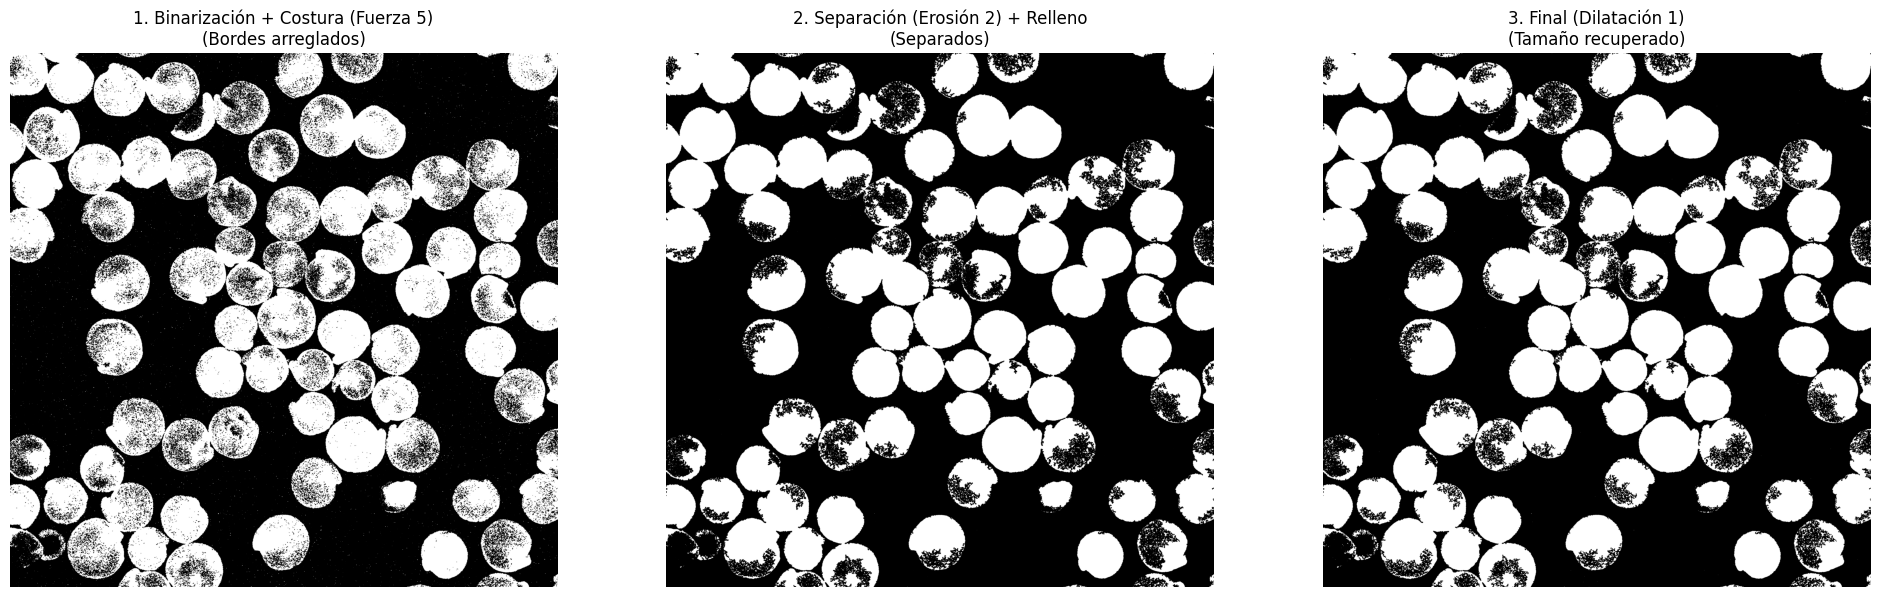

In [5]:
# --- ESTRATEGIA COMPLETA: Costura -> Separar -> Rellenar -> Recuperar ---

# AJUSTES MANUALES
UMBRAL = 60              # Luz
FUERZA_COSTURA = 5       # Cierra bordes rotos ANTES de separar
ITER_EROSION = 2        # Fuerza de separación
ITER_DILATACION = 1    # Recuperar tamaño

# 1. Binarización Directa
ret, binaria = cv2.threshold(y_combined, UMBRAL, 255, cv2.THRESH_BINARY)

# 2. COSTURA
# Cierra pequeños huecos o bordes rotos antes de erosionar
kernel_costura = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (FUERZA_COSTURA, FUERZA_COSTURA))
binaria_cerrada = cv2.morphologyEx(binaria, cv2.MORPH_CLOSE, kernel_costura)

# 3. EROSIÓN
# "Come" los bordes para romper las uniones
kernel = np.ones((3, 3), np.uint8)
img_separada = cv2.erode(binaria_cerrada, kernel, iterations=ITER_EROSION)

# 4. RELLENO DE AGUJEROS
# Convertimos lo que quedó en círculos sólidos
contornos, _ = cv2.findContours(img_separada, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
img_solida = np.zeros_like(img_separada)
cv2.drawContours(img_solida, contornos, -1, 255, cv2.FILLED)

# 5. DILATACIÓN
# "Engorda" los granos de nuevo para que tengan su tamaño real
kernel_redondo = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
img_final = cv2.dilate(img_solida, kernel_redondo, iterations=ITER_DILATACION)

# --- VISUALIZACIÓN ---
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

# Mostramos la imagen con costura (mejorada) en lugar de la binaria cruda
axes[0].imshow(binaria_cerrada, cmap='gray')
axes[0].set_title(f"1. Binarización + Costura (Fuerza {FUERZA_COSTURA})\n(Bordes arreglados)")
axes[0].axis('off')

axes[1].imshow(img_solida, cmap='gray')
axes[1].set_title(f"2. Separación (Erosión {ITER_EROSION}) + Relleno\n(Separados)")
axes[1].axis('off')

axes[2].imshow(img_final, cmap='gray')
axes[2].set_title(f"3. Final (Dilatación {ITER_DILATACION})\n(Tamaño recuperado)")
axes[2].axis('off')

plt.show()

La imagen ya está en escala de grises. Se omite la conversión.


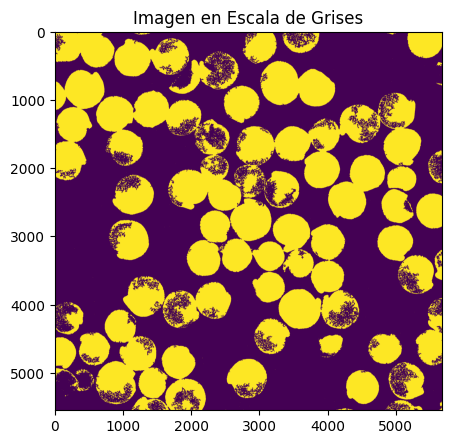

In [14]:
#########################
## FUNCIONES DE UTILIDAD ##
#########################

def plotSingle(img, title):
    plt.title(title)
    plt.imshow(img)
    plt.show()

def plotMulti(imgArr, Titles):
    fig = plt.figure(figsize=(5*len(imgArr), 5))
    indx = 0
    for img in imgArr:
        indx = indx + 1
        a = fig.add_subplot(1, len(imgArr), indx)

        # Verificamos si la imagen tiene 2 dimensiones (escala de grises)
        # para aplicar el mapa de color 'gray', si no, se muestra normal.
        if len(img.shape) == 2:
            imgplot = plt.imshow(img) #, cmap='gray')
        else:
            # Nota: Si img_final está en BGR (formato OpenCV), los colores pueden verse invertidos
            # en Matplotlib. Si se ve azulada, usa: cv2.cvtColor(img, cv2.COLOR_BGR2RGB) aquí.
            imgplot = plt.imshow(img)

        a.set_title(Titles[indx-1])
    plt.show()

# 1. Verificar dimensiones antes de convertir
# Si len(img.shape) es 2, la imagen ya es 2D (escala de grises)
if len(img_final.shape) == 2:
    print("La imagen ya está en escala de grises. Se omite la conversión.")
    Gray = img_final.copy() # Usamos una copia directa
else:
    # Si tiene 3 dimensiones (Alto, Ancho, Canales), convertimos
    print("Convirtiendo imagen de color a escala de grises...")
    Gray = cv2.cvtColor(img_final, cv2.COLOR_BGR2GRAY)

# Graficamos
# Nota: Si img_final es gris, ambas se verán igual
plotMulti([Gray], ["Imagen en Escala de Grises"])

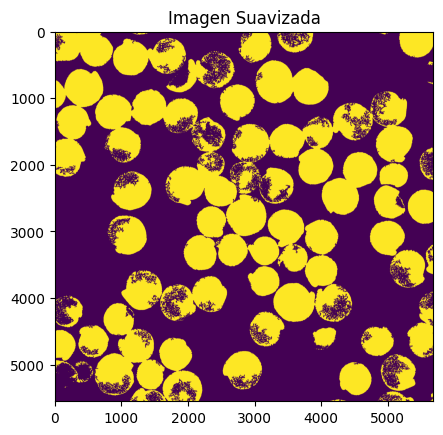

In [15]:
# 2. Antes de realizar la implementación de watershed, la imagen necesita ser
#    preprocesada para eliminar cualquier ruido o detalles no deseados.
blur = cv2.medianBlur(Gray, 5)
plotSingle(blur, "Imagen Suavizada")

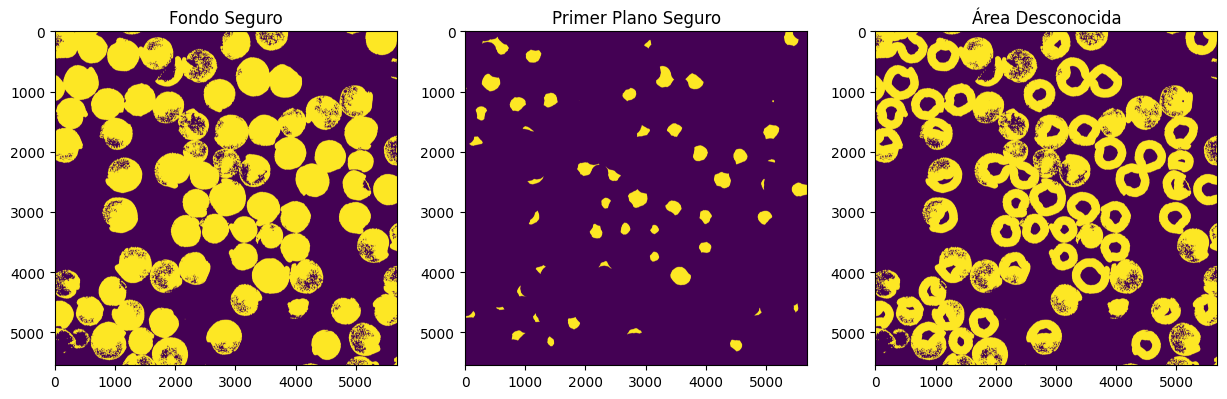

In [17]:
# 4. Necesitamos encontrar el primer plano (foreground) seguro y el fondo
#    (background) seguro de la imagen.
#    Esto es para encontrar la región desconocida restándolos y obtener los límites.

kernel = np.ones((3,3), np.uint8)
# Se aplica una operación de apertura (erosión seguida de dilatación) para quitar ruido blanco
opening = cv2.morphologyEx(blur, cv2.MORPH_OPEN, kernel, iterations = 1)

# Área de fondo segura: dilatamos la imagen de apertura para obtener el
# fondo 100% verdadero de la imagen.
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Encontrar el área de primer plano segura: Encontrar el primer plano seguro de la
# imagen es un poco más complicado. Usamos la transformada de distancia para obtener
# el mapa de distancias, que es un mapa que asigna a cada píxel la distancia al
# píxel de fondo más cercano. Esto básicamente mide qué tan lejos está cada píxel
# del borde de los objetos. Los mapas de distancia proporcionan una representación
# más precisa de los límites de los objetos, ya que toman en cuenta la distancia
# desde cada píxel hasta el fondo.
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)

# Luego aplicamos un segundo umbral para permitir que los píxeles más brillantes
# permanezcan mientras que los otros se eliminan de la imagen. Esto permite que
# los objetos se separen entre sí (donde la distancia es máxima).
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)

# Encontrar la región desconocida. En esta área no podemos asegurar si es
# verdaderamente primer plano o fondo. Watershed debería hacer el trabajo y averiguarlo.
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

imgArr = [sure_bg, sure_fg, unknown]
Titles = ["Fondo Seguro", "Primer Plano Seguro", "Área Desconocida"]
plotMulti(imgArr, Titles)

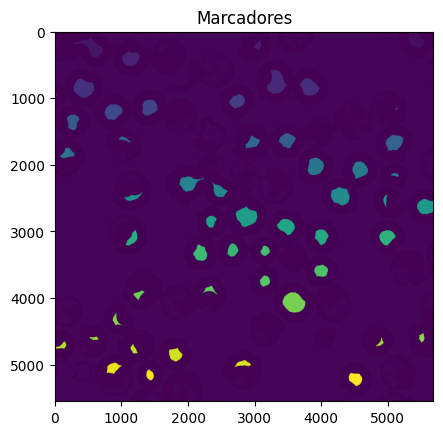

In [18]:
# 5. Necesitamos encontrar los marcadores. Los marcadores son los puntos que definen las
#    regiones en la imagen. Estos definen los objetos de interés en la imagen.
#    Los marcadores son semillas esenciales que se utilizan para inundar la imagen y separar
#    los objetos entre sí.

# Etiquetado de marcadores
ret, markers = cv2.connectedComponents(sure_fg)

# Sumar uno a todas las etiquetas para que el fondo seguro no sea 0, sino 1
markers = markers + 1

# Ahora, marcar la región desconocida con cero
markers[unknown == 255] = 0

plotSingle(markers, "Marcadores")

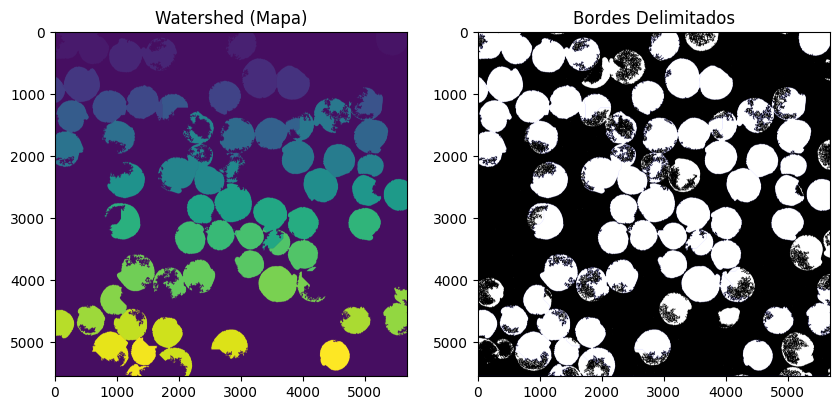

In [20]:
# 6. Ejecutamos el algoritmo watershed.
#    IMPORTANTE: cv2.watershed SOLO funciona si la imagen de entrada tiene 3 canales (Color).
#    Como nuestra 'img_final' es de 1 canal (Grises), debemos convertirla a BGR primero.

if len(img_final.shape) == 2:
    # Convertimos de Grises a BGR (Color) para que watershed no de error
    img_color_para_watershed = cv2.cvtColor(img_final, cv2.COLOR_GRAY2BGR)
else:
    img_color_para_watershed = img_final.copy()

# Aplicamos watershed sobre esta imagen de 3 canales
watershed = cv2.watershed(img_color_para_watershed, markers)

# En la imagen de color, pintamos los bordes encontrados (donde watershed es -1)
# Usamos [0, 0, 255] que es Rojo (en formato BGR)
img_color_para_watershed[watershed == -1] = [0, 0, 255]

plotMulti([watershed, img_color_para_watershed], ["Watershed (Mapa)", "Bordes Delimitados"])

Calculando medidas avanzadas...
=== MEDIDAS AVANZADAS ===


,ID,Area,Perimetro,Solidez,Convexidad,Extension_Caja,Extension_Circulo,Elongacion,Excentricidad,Relacion_Radios,Rizo_Aprox
0,2,173127.5,1790.472208,0.983291,1.134820,0.839138,0.733562,1.052763,0.312611,0.708334,0.617914
1,3,347200.0,4672.654209,0.854421,1.870938,0.742845,0.507705,1.615694,0.785447,0.475579,0.371000
2,4,156977.0,3684.914093,0.859258,2.386198,0.665239,0.717785,1.216364,0.569311,0.687840,0.271797
3,5,389229.0,8898.106527,0.735976,3.166164,0.634778,0.412607,2.145840,0.884775,0.439056,0.250692
4,6,279330.0,3273.894766,0.953333,1.692791,0.738125,0.840047,1.186640,0.538359,0.751762,0.396066
5,7,223409.0,1926.812390,0.977726,1.123494,0.746728,0.880647,1.088693,0.395345,0.869062,0.582320
6,8,255143.0,2228.400268,0.959370,1.202119,0.712598,0.847780,1.047458,0.297596,0.824989,0.528047
7,9,47039.0,1209.293499,0.912006,1.204834,0.605393,0.340817,1.050600,0.306606,0.381678,0.666975
8,10,205599.5,2492.927168,0.952136,1.500912,0.713392,0.864352,1.048740,0.301313,0.833157,0.422280
9,11,235526.0,2779.998236,0.891109,1.465872,0.717356,0.655093,1.183339,0.534661,0.716965,0.446732


Archivo guardado exitosamente como: medidas_avanzadas.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Descargando archivo a tu computadora...


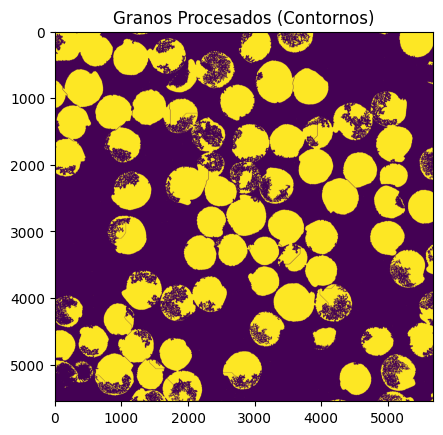

In [23]:
import pandas as pd
import math

# 8. CÁLCULO DE MEDIDAS AVANZADAS (PDI)

labels = np.unique(watershed)
data_avanzada = []
img_contours = img_final.copy() # Copia de la imagen final para dibujar los contornos

print("Calculando medidas avanzadas...")

for label in labels:
    # Ignoramos el fondo (1) y los bordes (-1) generados por watershed
    if label == 1 or label == -1:
        continue

    # 1. Crear máscara individual para este grano específico
    mask = np.zeros(watershed.shape, dtype="uint8")
    mask[watershed == label] = 255

    # 2. Encontrar contornos en la máscara
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(cnts) > 0:
        c = cnts[0]

        # --- VARIABLES BÁSICAS ---
        area = cv2.contourArea(c) # Área Neta
        if area == 0: continue # Evitar errores en granos diminutos (ruido)

        perimeter = cv2.arcLength(c, True) # Perímetro

        # Convex Hull (Envoltura convexa)
        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        hull_perimeter = cv2.arcLength(hull, True)

        # Bounding Box (Rectángulo delimitador recto)
        x, y, w, h = cv2.boundingRect(c)
        bbox_area = w * h

        # Minimum Enclosing Circle (Círculo Circunscrito Mínimo)
        (x_circ, y_circ), radius_circum = cv2.minEnclosingCircle(c)
        circle_area = np.pi * (radius_circum ** 2)

        # Fit Ellipse (Elipse ajustada) para obtener Ejes Mayor y Menor
        # Se necesitan al menos 5 puntos para ajustar una elipse matemáticamente
        if len(c) >= 5:
            (center, (axis1, axis2), angle) = cv2.fitEllipse(c)
            # Ordenamos ejes: axis1 y axis2 pueden venir desordenados
            major_axis = max(axis1, axis2)
            minor_axis = min(axis1, axis2)
        else:
            major_axis = max(w, h)
            minor_axis = min(w, h)

        # Radio Inscrito (Inscribed Radius)
        # Usamos la transformada de distancia: el valor máximo dentro de la máscara
        # corresponde al radio del círculo más grande que cabe dentro del objeto.
        dist = cv2.distanceTransform(mask, cv2.DIST_L2, 5)
        radius_inscribed = dist.max()

        # --- APLICANDO LAS FÓRMULAS DE MEDIDAS DE FORMA ---

        # 1. Solidez (Solidity) = Área / Área de la Envoltura Convexa
        # Mide cuán sólido o compacto es un objeto (sin huecos ni entradas profundas).
        solidity = area / hull_area if hull_area > 0 else 0

        # 2. Convexidad (Convexity) = Perímetro / Perímetro de la Envoltura Convexa
        # Mide la rugosidad del borde.
        convexity = perimeter / hull_perimeter if hull_perimeter > 0 else 0

        # 3. Extensión Caja (Extent) = Área / Área del Rectángulo Delimitador
        extent1 = area / bbox_area if bbox_area > 0 else 0

        # 4. Extensión Círculo = Área / Área del Círculo Circunscrito
        extent2 = area / circle_area if circle_area > 0 else 0

        # 5. Elongación = Eje Mayor / Eje Menor
        # Indica qué tan alargado es el objeto.
        elongation = major_axis / minor_axis if minor_axis > 0 else 0

        # 6. Excentricidad = sqrt(a^2 - b^2) / a
        # a = semi-eje mayor, b = semi-eje menor. 0 es un círculo, cerca de 1 es una línea.
        a = major_axis / 2
        b = minor_axis / 2
        if a > 0:
            eccentricity = math.sqrt(abs(a**2 - b**2)) / a
        else:
            eccentricity = 0

        # 7. Relación de Radios = Radio Inscrito / Radio Circunscrito
        radius_ratio = radius_inscribed / radius_circum if radius_circum > 0 else 0

        # 8. Fracción de Área = Área Neta / Área Rellena
        # Como trabajamos con máscaras sólidas, asumimos 1.0.
        area_fraction = 1.0

        # 9. Rizo (Curl) = Longitud / Longitud de la Fibra
        # Aproximación: Eje Mayor / (Perímetro / 2). Mide qué tan "enrollado" está el objeto.
        curl = major_axis / (perimeter / 2) if perimeter > 0 else 0

        # --- GUARDAR DATOS EN LA LISTA ---
        data_avanzada.append({
            "ID": label,
            "Area": area,
            "Perimetro": perimeter,
            "Solidez": solidity,
            "Convexidad": convexity,
            "Extension_Caja": extent1,
            "Extension_Circulo": extent2,
            "Elongacion": elongation,
            "Excentricidad": eccentricity,
            "Relacion_Radios": radius_ratio,
            "Rizo_Aprox": curl
        })

        # Dibujar el contorno en verde para verificar visualmente que se detectó bien
        cv2.drawContours(img_contours, [c], -1, (0, 255, 0), 2)

# ... (Todo el código anterior de cálculo de medidas sigue igual) ...

# --- RESULTADOS ---
df_avanzado = pd.DataFrame(data_avanzada)

# Mostrar tabla
print("=== MEDIDAS AVANZADAS ===")
pd.set_option('display.max_columns', None)
display(df_avanzado.head(10))

# --- SOLUCIÓN PARA GUARDAR ---
# Guardamos solo con el nombre del archivo
nombre_archivo = "medidas_avanzadas.csv"
df_avanzado.to_csv(nombre_archivo, index=False)

print(f"Archivo guardado exitosamente como: {nombre_archivo}")

# Código opcional para descargar el archivo automáticamente a tu PC
try:
    from google.colab import files
    files.download(nombre_archivo)
    print("Descargando archivo a tu computadora...")
except Exception as e:
    print("No se pudo descargar automáticamente. Búscalo en la carpeta de archivos a la izquierda.")

# Mostrar imagen con los contornos procesados
plotSingle(img_contours, "Granos Procesados (Contornos)")